In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from fastai.vision import *
from torch import nn
from collections import defaultdict
from torch.utils.data import SequentialSampler
from fastai3D import mysampler
#from fastai3D import functions
#from fastai3D import loader #does not comply 

In [3]:
path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train') #suze_device
#path = Path('/home/suze/seed_images/Data_for_ML_Test//test_model/Barley_test')
path.ls()

[PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/NewLabels'),
 PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/Barley_big.pkl'),
 PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/Images'),
 PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/Test'),
 PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/models'),
 PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/valid.txt'),
 PosixPath('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train/environment.yml')]

In [4]:
path_img = path/'Images' #should later be provided through ini file
#path_lbl = path/'Labels' #should later be provided through ini file #suze_device
path_lbl = path/'NewLabels' #should later be provided through ini file

Uncomment in case of file issues

In [5]:
#img_names=get_image_files(path_img)
#img_names[:3]
#lbl_names=get_image_files(path_lbl)
#lbl_names[:3]

function to find mask matching the image

In [6]:
def get_mask(img):
    return (path_lbl)/img.name

In [7]:
#def get_mask(x):
#    return PosixPath(str(x)
#            .replace('train','NewLabels')
#            .replace('valid','NewLabels'))
            #.replace('resampled', 'labels'))

uncomment for error testing

In [8]:
#mask = open_mask(get_mask(img_names[0]))
#mask.show()
#img = open_image(img_names[0])
#img.show()

In [9]:
#src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [10]:
def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

"""function to filter out images that only contain background; used to filter in the API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

### Calculate appropriate weights
still needs some tweaking to exclude valid set

In [11]:
#%time classes_count = count_mask(img_names)
#classes_count
#slow for big sets, make faster?
classes_count = defaultdict(int, {0: 796196338, 1: 240902526, 2: 25500623, 3: 21869121})

In [12]:
#append occurences in a list 
#seems redundant
#counts = []
#for c in classes_count:
#    counts.append(classes_count[c])
#counts
counts = [796196338, 240902526, 25500623, 21869121]

In [13]:
#weight_ratios =[min(counts)/x for x in counts]
#weight_ratios
weight_ratios = [0.02746699520740574, 0.09077995720144504, 0.8575916360945378, 1.0]

# Data Loading
Load in data and apply transformations etc

In [14]:
src = (SegmentationItemList.from_folder(path)
       #.split_subsets(train_size=0.2, valid_size=0.1)
       .filter_by_func(check_back)
       .split_by_fname_file('valid.txt')
       .label_from_func(get_mask, classes=list(range(4))))

In [15]:
data = (src.transform(get_transforms(), tfm_y=True, size=128)
       .databunch(bs=1)
       .normalize())
#data.show_batch(4, figsize=(10,7))
#data.batch_size

### Change to custom sampler for order within batches

In [16]:
from fastai3D import loader
data.train_dl = data.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data.train_dl), 6, True))

In [17]:
data

ImageDataBunch;

Train: LabelList (4099 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train;

Valid: LabelList (200 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train;

Test: None

In [18]:
#data
#print(data.batch_size)

# Create learner

In [19]:
metrics=acc_seeds
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

In [21]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


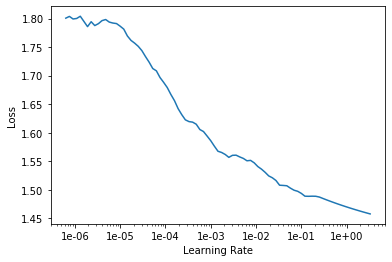

In [81]:
learn.lr_find()
learn.recorder.plot()

# Start learning

In [75]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-4)

epoch,train_loss,valid_loss,acc_seeds,time
0,0.992620,1.060714,0.475229,18:12


In [66]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

In [51]:
#append extra layers to model
learn.model[:]
#learn.model[:].append(learn.model[:])

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [22]:
def conv3_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               is_2d:bool = False, trans_2d:bool = False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose3d if transpose else nn.Conv1d if is_1d else nn.ConvTranspose2d if trans_2d else nn.Conv2d if is_2d else nn.Conv3d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d if is_2d else nn.BatchNorm3d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [23]:
#both need to be walked through again, as batch_size dimensions don't match when predicting
#ValueError: Expected input batch_size (512) to match target batch_size (16384).
stack_layers = nn.Sequential(
    Lambda(lambda x: torch.stack(tuple(x), dim = 3)),
    Lambda(lambda x: torch.unsqueeze(x,0))
)

#unstack_layers = nn.Sequential(
#    Lambda(lambda x: torch.transpose(x, 0 , 4)),
#    Lambda(lambda x: x.squeeze())
#)

unstack_layers = nn.Sequential(
    Lambda(lambda x: torch.squeeze(x, dim = 0)),
    Lambda(lambda x: torch.stack(torch.unbind(x, dim = 3), dim =0))
    #Lambda(lambda x: torch.stack(x, dim = 0))
)

In [24]:
#see what addition of layer looks like
#learn.model[:].append(conv3_layer(3, 64))
#learn.model[:].append(stack_layers)
learn.model.append(stack_layers)

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

In [56]:
learn.model[:]

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [26]:
#add layer
#learn.model.append(nn.Conv3d(4,  16, kernel_size=3, stride=2, padding=1))
learn.model.append(conv3_layer(4, 64))
#learn.model.append(MergeLayer())
#learn.model.append(conv3_layer(64, 4))

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
learn.summary()

RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 2

In [27]:
learn.model.append(unstack_layers)

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [28]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

In [61]:
for xb, yb in data.train_dl:
    #out = model[xb]
    out = (learn.model(*[xb]))
    #outy = (model(*[yb]))
    #print(xb.size())
    print(out.size())
    #print(yb.size())
    #print(outy.size())
    break

torch.Size([6, 4, 128, 128])


In [46]:
out

tensor([[[[1.3968e+00, 2.4672e-01, 1.0175e+00,  ..., 2.0069e+00,
           0.0000e+00, 1.7083e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.2420e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8511e-01, 5.4225e+00, 8.0442e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 8.2345e+00,  ..., 0.0000e+00,
           0.0000e+00, 9.7850e-01],
          [1.5957e+00, 5.6493e+00, 8.3402e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.0237e+00]],

         [[1.0487e+00, 2.7438e+00, 1.1805e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.4342e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7074e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [ ]:
#a_batch = data.one_batch(detach=True)
#a_batch
#a_batch[0].size()

In [ ]:
#learn.show_results()

In [ ]:
#learn.freeze()

In [ ]:
#learn.save('stage-1')

In [ ]:
#learn.load('stage-1');

In [ ]:
#learn.unfreeze()

In [ ]:
#lrs = slice(3e-5/100, 3e-5)

In [ ]:
#learn.fit_one_cycle(4, lrs)

In [ ]:
#from fastai.vision.interpret import *
#interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
#top_losses, top_idxs = interp.top_losses(sizes=(128,128))

In [ ]:
#mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
#df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
from torch import nn

model = nn.Sequential(
    nn.Conv3d(n_class, 32), 
    nn.BatchNorm3d()
    nn.ReLU(),

    nn.Conv3d(32, 64), 
    nn.BatchNorm3d()
    nn.ReLU(),
    #skip connection 1
    nn.MaxPool3d(),

    nn.Conv3d(64, 64),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(64, 128),
    nn.BatchNorm3d(),
    nn.ReLU(),
    #skip connection 2
    nn.MaxPool3d(),

    nn.Conv3d(128, 128),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(128, 256),
    nn.BatchNorm3d(),
    nn.ReLU(),  
    #skip connection 3
    nn.MaxPool3d(),  

    nn.Conv3d(256, 256),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(256, 512),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.ConvTranspose3d(512, 512)
    #concat with skip 3

    nn.Conv3d(768, 256),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(256, 256),
    nn.BatchNorm3d(),
    nn.ReLU(),
    nn.ConvTranspose3d(256, 256)
    #concat with skip 2

    nn.Conv3d(384, 128),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(128, 128),
    nn.BatchNorm3d(),
    nn.ReLU(),
    nn.ConvTranspose3d(128, 128)
    #concat with skip 1

    nn.Conv3d(172, 64),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(64, 64),
    nn.BatchNorm3d(),
    nn.ReLU(),

    nn.Conv3d(64, n_class)


    # #fastai basic block
    # nn.Conv3d(),
    # nn.BatchNorm3d(),
    # nn.ReLU(),
    # nn.Conv3d(), 
    # nn.BatchNorm3d(),

    # Mergelayer(),



    )